# Summary

This notebook loads the final classification model used for bridge rating prediction. Specific features that influence prediction are extracted from the model and their relative importance is analyzed. 

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [3]:
from sklearn import metrics
from sklearn.externals import joblib

## Plot Settings

In [4]:
# format style
plt.style.use('fivethirtyeight')
# lineweight
plt.rc('lines', linewidth=3)
# figure size
plt.rc('figure', figsize=(12, 7))
# title fontsize
plt.rc('axes', titlesize=33) 
# axes label fontsize
plt.rc('axes', labelsize=28)
# axes values fontsize
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
# legend fontsize
plt.rc('legend', fontsize=18)

## Feature Weight Sorting

In [5]:
class FeatureSort():
    '''
    Sort (in descending order) feature weights for Linear Regression or Logistic Regression models
    
    Parameters
    ----------
    weights : array of feature weights from model
    labels : list of feature labels
    '''
    
    def __init__(self, weights, labels):
        
        self.weights = weights
        self.labels = labels
    
    
    def sort_wgts(self, num_ret='all', ret_0=False):
        '''
        Sort feature weights (greatest to least)
        
        Parameters
        ----------
        num_ret : number of top features to return
        ret_0 : return weights with value of zero
        '''
        
        # create feature weight dataframe
        self.df = pd.DataFrame(self.weights, index=self.labels, columns=['feat_wgt']).copy()
        
        # sort feature weight dataframe
        self.df.sort_values(by='feat_wgt', ascending=False, inplace=True)
        
        # 0 values
        if ret_0 == False:
            # drop weights == 0
            self.df = self.df[self.df.iloc[:, 0] != 0]
        
        # top number of features to return
        if num_ret != 'all':
            # slice number of rows in dataframe
            self.df = self.df.iloc[:num_ret, :]

        # return dataframe
        return(self.df)

    
    
    def sort_abs(self, num_ret='all', ret_0=False):
        '''
        Sort feature weights (greatest to least) based on absolute values

        Parameters
        ----------
        num_ret : number of top features to return
        ret_0 : return weights with value of zero
        '''
        
        # create feature weight dataframe
        self.df = pd.DataFrame(self.weights, index=self.labels, columns=['feat_wgt']).copy()
        
        # create column identifying positive weights
        self.df['positive'] = self.df['feat_wgt'] > 0
        # transform weights to absolute value
        self.df['feat_wgt'] = self.df['feat_wgt'].apply(abs)
        # sort feature weight dataframe
        self.df.sort_values(by='feat_wgt', ascending=False, inplace=True)
        
        # 0 values
        if ret_0 == False:
            # drop weights == 0
            self.df = self.df[self.df.iloc[:, 0] != 0]
            
        # top number of features to return
        if num_ret != 'all':
            # slice number of rows in dataframe
            self.df = self.df.iloc[:num_ret, :]

        # return dataframe
        return(self.df)
    
    
    def sort_pct(self, num_ret='all', ret_0=False, rnd=1):
        '''
        Sort feature weights (greatest to least) and return as percentage values
        
        Parameters
        ----------
        num_ret : number of top features to return
        ret_0 : return weights with value of zero
        rnd : decimal precision for rounding
        '''
        
        # create feature weight dataframe
        self.df = pd.DataFrame(self.weights, index=self.labels, columns=['feat_wgt']).copy()
        
        # create column identifying positive weights
        self.df['positive'] = self.df['feat_wgt'] > 0
        # transform weights to absolute value
        self.df['feat_wgt'] = self.df['feat_wgt'].apply(abs)
        # sort weights
        self.df.sort_values(by='feat_wgt', ascending=False, inplace=True)
        # transform weights to percentages
        self.df['feat_wgt'] = round(self.df['feat_wgt'] / self.df['feat_wgt'].sum() * 100, rnd)
        # rename column
        col_rename = self.df.columns.values
        col_rename[0] = 'feat_%'
        self.df.columns = col_rename
        
        # 0 values
        if ret_0 == False:
            # drop weights == 0
            self.df = self.df[self.df.iloc[:, 0] != 0]
            
        # top number of features to return
        if num_ret != 'all':
            # slice number of rows in dataframe
            self.df = self.df.iloc[:num_ret, :]

        # return dataframe
        return(self.df)  

## Plot Feature Affects

In [6]:
def feat_plot(df_feats, feat_lab='df_idx'):
    '''
    Return plot of positive and negative feature affects for bridge performance
    
    Parameters
    ----------
    df_feats : dataframe of a model's feature affect values and if positive
    feat_lab : labels for feature affects, default is dataframe index
    '''
    
    # define feature labels
    if feat_lab == 'df_idx':
        feat_lab = df_feats.index
    
    # initialize plot
    ax = plt.gca()
    # plot feature affects with positive and negative differentiation
    df_feats.iloc[:, 0].plot(kind='bar', ax=ax, color=df_feats.iloc[:, 1]
                            .map({True: 'r', False: 'g'})) # modified so true (positive) is red
    ax.set_title('Affect on Bridge Performance')
    ax.set_xlabel('NBI Item')
    ax.set_ylabel('Affect (%)')
    # set x-tick labels to feature labels
    ax.set_xticklabels(feat_lab)
    
    # positive label for legend
    pos_patch = mpatches.Patch(color='green', label='Positive')
    # negative label for legend
    neg_patch = mpatches.Patch(color='red', label='Negative')
    # display legend
    legend = plt.legend(title='Correlation', handles=[pos_patch, neg_patch])
    legend.get_title().set_fontsize('18')

# Model Results

In [7]:
# load saved model
log_pipe = joblib.load('model_output/model.sav')

In [8]:
# load feature data
X = pd.read_csv('data/feat_df.csv', index_col=0)
features = X.columns

In [9]:
# load true classes
y = pd.read_csv('data/tru_cls.csv', index_col=0, header=None)

In [10]:
# load bridge ID info
br_id = pd.read_csv('data/bridges_id.csv', index_col=0)

## Feature Affects

In [11]:
# return top 10 feature affects
feat_inst = FeatureSort(log_pipe.named_steps['model'].coef_[0], features)
feat_df = feat_inst.sort_pct(10)
feat_df

,feat_%,positive
SUFFICIENCY_RATING_feat_yr,14.1,False
SUPERSTRUCTURE_COND_059_8,7.1,False
DECK_STRUCTURE_TYPE_107_8,5.0,True
SUPERSTRUCTURE_COND_059_7,3.4,False
STRUCTURE_KIND_043A_1,3.1,False
SURFACE_TYPE_108A_3,2.8,False
HISTORY_037_4.0,2.4,True
FUNCTIONAL_CLASS_026_16.0,2.2,True
OPEN_CLOSED_POSTED_041_P,2.0,True
SERVICE_UND_042B_1,2.0,False


In [12]:
# percentage of model prediction based on top ten features
feat_df['feat_%'].sum()

44.1

In [13]:
# feature labels based on NBI guide
labels = [
    'Suff. Rating', 
    'Super Cond. 8', 
    'Wood Deck', 
    'Super Cond. 7', 
    'Conc. Super', 
    'Latex W.S.', 
    'Hist. Undet.',
    'Urb. Min. Arterial',
    'Posted for Load',
    'Highway Below'
]

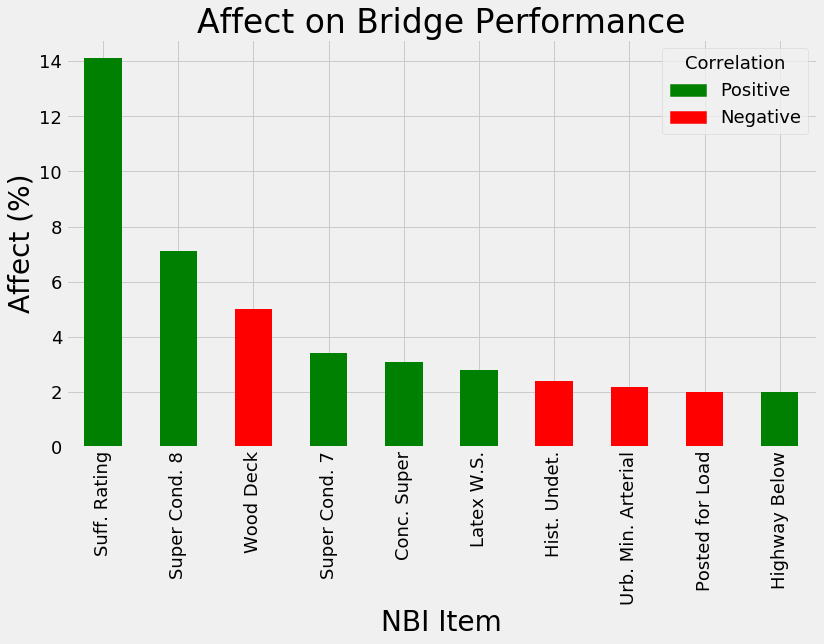

In [14]:
# plot most important features affecting predictions
feat_plot(feat_df, labels)
# plt.savefig('model_output/feat_wgt.png', bbox_inches='tight')

**Note**: Model assumes 'poor' as positive class.  
For display, the signs are reversed so that 'positive' indicates a feature that increases a bridge's performance life.

## Sample Bridges

In [15]:
X.head()

,MIN_VERT_CLR_010,DETOUR_KILOS_019,AGE,TRAFFIC_LANES_ON_028A,TRAFFIC_LANES_UND_028B,ADT_029,APPR_WIDTH_MT_032,DEGREES_SKEW_034,NAV_VERT_CLR_MT_039,NAV_HORR_CLR_MT_040,...,SUPERSTRUCTURE_COND_059_6,SUPERSTRUCTURE_COND_059_7,SUPERSTRUCTURE_COND_059_8,SUPERSTRUCTURE_COND_059_9,SUPERSTRUCTURE_COND_059_N,SUBSTRUCTURE_COND_060_4,SUBSTRUCTURE_COND_060_5,SUBSTRUCTURE_COND_060_6,SUBSTRUCTURE_COND_060_7,SUBSTRUCTURE_COND_060_8
51-1VA3701,99.99,2.0,53.0,2.0,0,2000.0,7.9,45.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
51-1VA591A,99.99,4.0,42.0,2.0,0,50.0,6.5,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
51-2VA00AA,99.99,22.0,60.0,2.0,0,2000.0,6.1,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,0,0
51-2VA00CC,99.99,6.0,60.0,2.0,0,1000.0,7.3,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
51-2VA00DD,99.99,12.0,60.0,2.0,0,500.0,6.1,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0


In [16]:
# average sufficiency rating
avg_SR = X['SUFFICIENCY_RATING_feat_yr'].mean()
avg_SR

69.71812080536903

### Arlington Co

In [17]:
# arlington co bridges
ar_co = br_id[br_id['COUNTY_CODE_003'] == 13].index

In [18]:
ar_br = y.loc[ar_co, :][y.loc[ar_co, :][1] == 'poor'].index
ar_br

Index(['51-000000000000003', '51-000000000000125', '51-000000000000217'], dtype='object')

In [19]:
X.loc[ar_br, :][feat_df.index]

,SUFFICIENCY_RATING_feat_yr,SUPERSTRUCTURE_COND_059_8,DECK_STRUCTURE_TYPE_107_8,SUPERSTRUCTURE_COND_059_7,STRUCTURE_KIND_043A_1,SURFACE_TYPE_108A_3,HISTORY_037_4.0,FUNCTIONAL_CLASS_026_16.0,OPEN_CLOSED_POSTED_041_P,SERVICE_UND_042B_1
51-000000000000003,51.0,0,0,1,0,0,0,1,0,1
51-000000000000125,62.0,0,0,0,1,0,1,0,0,1
51-000000000000217,66.0,0,0,0,0,0,0,0,0,0


In [65]:
br_id.loc[ar_br, :]

,COUNTY_CODE_003,FEATURES_DESC_006A,FACILITY_CARRIED_007,LOCATION_009
51-000000000000003,13.0,'RTE. 120 N. GLEBE ROAD ','OLD GLEBE ROAD ','02.01FR.309/00.30TO123 '
51-000000000000125,13.0,'ROUTE 244 COLUMBIA PIKE ','WASHINGTON BLVD. ','00.55FR110/00.82TO244 '
51-000000000000217,13.0,'PIMMITT RUN ','NORTH GLEBE ROAD ','01.08FR.698/00.03TO123 '


### Fairfax County

In [66]:
fair_co = br_id[br_id['COUNTY_CODE_003'] == 59].index

In [67]:
fair_br = y.loc[fair_co, :][y.loc[fair_co, :][1] == 'poor'].index

In [69]:
br_id.loc[fair_br, :]

,COUNTY_CODE_003,FEATURES_DESC_006A,FACILITY_CARRIED_007,LOCATION_009
51-000000000006198,59.0,'I-66 AND METRO ','VADEN DRIVE ','00.12FR6154/00.76TO243 '
51-000000000006463,59.0,'LEESBURG PIKE (RTE. 7) ','CHAINBRIDGE RD. ','0.68FR677/0.53TOINTER. DR'
51-000000000006465,59.0,'LEESBURG PIKE ROUTE 7 ','CHAINBRIDGE ROAD ','0.68FR677/0.53TOINTER. DR'
51-000000000006673,59.0,'POHICK CREEK ','OLD COLCHESTER RD.','0.90FR1 / 0.90TO242 '
51-000000000006793,59.0,'PINEY BRANCH ','POPES HEAD ROAD ','01.30FR.5435/00.60TO612 '
51-000000000006885,59.0,'I-495 & SCOTTS RUN ','OLD DOMINION DR. ','00.55FR685/00.50TO686 '


In [70]:
X.loc[fair_br, :][feat_df.index]

,SUFFICIENCY_RATING_feat_yr,SUPERSTRUCTURE_COND_059_8,DECK_STRUCTURE_TYPE_107_8,SUPERSTRUCTURE_COND_059_7,STRUCTURE_KIND_043A_1,SURFACE_TYPE_108A_3,HISTORY_037_4.0,FUNCTIONAL_CLASS_026_16.0,OPEN_CLOSED_POSTED_041_P,SERVICE_UND_042B_1
51-000000000006198,62.0,0,0,0,0,0,0,0,0,1
51-000000000006463,59.0,0,0,0,0,0,0,0,0,1
51-000000000006465,65.2,0,0,0,0,0,0,0,0,1
51-000000000006673,63.1,0,1,0,0,0,0,0,0,0
51-000000000006793,76.8,0,0,1,0,0,0,0,0,0
51-000000000006885,76.8,0,0,1,0,0,0,1,0,0


### Wood Deck

In [20]:
# filter bridges for top six feature criteria
br_filt = X[
    (X['SUFFICIENCY_RATING_feat_yr'] < avg_SR) & # below average initial SR
    (X['SUPERSTRUCTURE_COND_059_8'] == 0) & # superstructure condition rating NOT 8
    (X['DECK_STRUCTURE_TYPE_107_8'] == 1) & # wood decks
    (X['SUPERSTRUCTURE_COND_059_7'] == 0) & # superstructure condition rating NOT 7
    (X['STRUCTURE_KIND_043A_1'] == 0) & # superstructure material NOT concrete
    (X['SURFACE_TYPE_108A_3'] == 0) # wearing surface NOT latex
 ]

In [21]:
# bridge locations
br_id.loc[br_filt.index, :]

,COUNTY_CODE_003,FEATURES_DESC_006A,FACILITY_CARRIED_007,LOCATION_009
51-000000000000393,1.0,'ONANCOCK CK @ ONANCOCK ','MOUNT PROSPECT AVE','0.04 MI. TO RTE. T-1003 '
51-000000000000814,3.0,'TOTIER CREEK ','JAMES RIVER ROAD ','1.38 FR 625 / 0.45 TO 845'
51-000000000000881,3.0,'STOCKTON CREEK ','PATTERSON MILL LN.','0.80 FR 250/0.83 TO 688 '
51-000000000001119,5.0,'BLUE SPRING RUN ','ROUTE 0616 ','1.00 TO 618 & 0.50 TO 617'
51-000000000001247,7.0,'DEEP CREEK ','NAMOZINE RD. ','3.58 FR 614 & 1.62 TO 641'
51-000000000001261,7.0,'NIBBS CREEK ','WINTERHAM ROAD ','2.19 FR 718 & .31 TO 609 '
51-000000000001265,7.0,'BARKHOUSE BRANCH ','LODORE ROAD ','.60 FR 740 & 2.20 TO 661 '
51-000000000001449,9.0,'Little Piney River ','Little Piney Road ','2.20-Rt.698/2.20-Rt.781 '
51-000000000001584,11.0,'Stonewall Creek ','Dreaming Creek Rd.','1.85-Rt.721 / 0.35-Rt.624'
51-000000000001595,11.0,'Buck Creek ','Spring Grove Road ','0.15-Rt.647 / 1.95-Rt.608'


In [41]:
# filter to bridges in Fairfax or Loudon counties
br_locs = br_id.loc[br_filt.index, :][(br_id.loc[br_filt.index, :]['COUNTY_CODE_003'] == 59) | 
                                      (br_id.loc[br_filt.index, :]['COUNTY_CODE_003'] == 107)]
br_locs

,COUNTY_CODE_003,FEATURES_DESC_006A,FACILITY_CARRIED_007,LOCATION_009
51-000000000006673,59.0,'POHICK CREEK ','OLD COLCHESTER RD.','0.90FR1 / 0.90TO242 '
51-11283,107.0,'RICHARDS CREEK ','ASH GEORGE ROAD ','00.45FR691/00.01TO694 '
51-11375,107.0,'SUGARLAND RUN ','THOMAS AVENUE ','00.10FR821/00.10TO793 '


In [48]:
# features for filtered bridges
br_feats = br_filt.loc[br_locs.index, :]

In [45]:
# filtered bridge top features
br_filt.loc[br_locs.index, :][feat_df.index]

,SUFFICIENCY_RATING_feat_yr,SUPERSTRUCTURE_COND_059_8,DECK_STRUCTURE_TYPE_107_8,SUPERSTRUCTURE_COND_059_7,STRUCTURE_KIND_043A_1,SURFACE_TYPE_108A_3,HISTORY_037_4.0,FUNCTIONAL_CLASS_026_16.0,OPEN_CLOSED_POSTED_041_P,SERVICE_UND_042B_1
51-000000000006673,63.1,0,1,0,0,0,0,0,0,0
51-11283,50.4,0,1,0,0,0,0,0,1,0
51-11375,67.7,0,1,0,0,0,0,0,0,0


In [63]:
# return functional class and historical features
search = ['HISTORY', '026']
br_feats[br_feats.columns[br_feats.columns.str.contains('|'.join(search))]]

,FUNCTIONAL_CLASS_026_1.0,FUNCTIONAL_CLASS_026_11.0,FUNCTIONAL_CLASS_026_12.0,FUNCTIONAL_CLASS_026_14.0,FUNCTIONAL_CLASS_026_16.0,FUNCTIONAL_CLASS_026_17.0,FUNCTIONAL_CLASS_026_19.0,FUNCTIONAL_CLASS_026_2.0,FUNCTIONAL_CLASS_026_6.0,FUNCTIONAL_CLASS_026_7.0,FUNCTIONAL_CLASS_026_8.0,FUNCTIONAL_CLASS_026_9.0,HISTORY_037_1.0,HISTORY_037_2.0,HISTORY_037_3.0,HISTORY_037_4.0,HISTORY_037_5.0
51-000000000006673,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
51-11283,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
51-11375,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [64]:
# return posting and service under features
search = ['041', '042B']
br_feats[br_feats.columns[br_feats.columns.str.contains('|'.join(search))]]

,OPEN_CLOSED_POSTED_041_A,OPEN_CLOSED_POSTED_041_D,OPEN_CLOSED_POSTED_041_P,OPEN_CLOSED_POSTED_041_R,SERVICE_UND_042B_0,SERVICE_UND_042B_1,SERVICE_UND_042B_2,SERVICE_UND_042B_3,SERVICE_UND_042B_4,SERVICE_UND_042B_5,SERVICE_UND_042B_6,SERVICE_UND_042B_7,SERVICE_UND_042B_8
51-000000000006673,1,0,0,0,0,0,0,0,0,1,0,0,0
51-11283,0,0,1,0,0,0,0,0,0,1,0,0,0
51-11375,1,0,0,0,0,0,0,0,0,1,0,0,0


Other top features:
- 06673
    - Functional Class: Urban Collector
    - Historical Sig: not eligible
    - Posting: open
    - Service under: waterway
- 11283
    - Functional Class: Rural Local
    - Historical Sig: not eligible
    - Posting: posted for load
    - Service under: waterway
- 11375
    - Functional Class: Urban Local
    - Historical Sig: not eligible
    - Posting: open
    - Service under: waterway